# Fireveg DB - graph of existing sources of plant trait data

Author: [José R. Ferrer-Paris](https://github.com/jrfep) and [Ada Sánchez-Mercado](https://github.com/adasanchez)

Date: July 2024

This Jupyter Notebook includes R code to visualise data from the Fireveg Database. 

The input is loaded from a public data record of the database.

We use this code to create a graph of traits (labelled rectangles) per published source (circles) used to document 14 fire ecology traits. Size of rectangles and circles is proportional to number of species with data from each trait/source.


## Set-up

### Load packages

In [1]:
library(ggplot2)
library(dplyr)
require(tidyr)
library(igraph)
library(ggraph)
require(osfr)
library(jsonlite)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: osfr

Automatically registered OSF personal access token



### Paths for inputs and outputs

Locate the root directory of the repo

In [2]:
here::i_am("Notebooks/Graph-existing-sources-traits.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



Relative path to local data files within project repository

In [3]:
data_dir <- here::here("data")
if (!dir.exists(data_dir))
    dir.create(data_dir)

### Download data from OSF

 <div class="alert alert-info">
     <img src='../img/open-data-2.png' width=25 alt="open data icon"/>
Data for this Notebook is available from the following OSF repository:

> Ferrer-Paris, J. R., Keith, D., & Sánchez-Mercado, A. (2024, August 15). Export data records from Fire Ecology Traits for Plants database. Retrieved from [osf.io/h96q2](https://osf.io/h96q2/)
</div>

Here we will download data programmatically from OSF cloud storage to our local data folder. First we will check the metadata for the target file. We use the `osf_ls_files` function from package `osfr` to explore the metadata of the file associated to the OSF component.

In [4]:
osf_project <- osf_retrieve_node("https://osf.io/h96q2")
file_list <- osf_ls_files(osf_project, pattern="Summary-traits-sources.rds")

In [5]:
str(file_list$meta,3)

List of 1
 $ :List of 3
  ..$ attributes   :List of 16
  .. ..$ guid                    : NULL
  .. ..$ checkout                : NULL
  .. ..$ name                    : chr "Summary-traits-sources.rds"
  .. ..$ kind                    : chr "file"
  .. ..$ path                    : chr "/64966f6fa2a2f4075a436743"
  .. ..$ size                    : int 1195532
  .. ..$ provider                : chr "osfstorage"
  .. ..$ materialized_path       : chr "/Summary-traits-sources.rds"
  .. ..$ last_touched            : NULL
  .. ..$ date_modified           : POSIXct[1:1], format: "2024-08-23 09:57:39"
  .. ..$ date_created            : POSIXct[1:1], format: "2023-06-24 04:22:07"
  .. ..$ extra                   :List of 2
  .. ..$ tags                    : list()
  .. ..$ current_user_can_comment: logi TRUE
  .. ..$ current_version         : int 4
  .. ..$ show_as_unviewed        : logi TRUE
  ..$ links        :List of 8
  .. ..$ info    : chr "https://api.osf.io/v2/files/64966f6fa2a2f4075a4

To download the latest version we apply the `osf_download` function with option `conflicts="overwrite"`. 
If we already have the latest version we can choose option `conflicts="skip"`.

In [6]:
RDSfile <- here::here(data_dir,'Summary-traits-sources.rds')

osf_download(file_list,
             data_dir,
             conflicts = "skip")


name                       id                      
1 Summary-traits-sources.rds 64966f6fa2a2f4075a436743
  local_path                                                                        
1 /Users/z3529065/proyectos/fireveg/fireveg-analysis/data/Summary-traits-sources.rds
  meta                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

**What about older versions?**

We can request more complete version information with a direct call to the API using the `read_json` function:

In [7]:
file_versions <- read_json(file_list$meta[[1]]$relationships$versions$links$related$href)

And we could use these urls to download specific versions:

In [8]:
results <- lapply(file_versions$data, function(x) {
    sprintf("version id %s from %s available at %s\n",
            x$id,
            x$attributes$date_created,
            x$links$download)
})
for (res in results) 
    cat(res)

version id 4 from 2024-08-23T09:57:39.979990 available at https://osf.io/download/64966f6fa2a2f4075a436743/?revision=4
version id 3 from 2024-08-22T12:28:22.708893 available at https://osf.io/download/64966f6fa2a2f4075a436743/?revision=3
version id 2 from 2024-08-14T21:45:47.107600 available at https://osf.io/download/64966f6fa2a2f4075a436743/?revision=2
version id 1 from 2023-06-24T04:22:07.756864 available at https://osf.io/download/64966f6fa2a2f4075a436743/?revision=1


### Read data from local folder

The data is now available in our local data folder and we can use `readRDS` to read this file into our R session:

In [9]:
traits_table <- readRDS(here::here(data_dir,'Summary-traits-sources.rds'))

## Visualise graph of references


The fireveg database incorporates records from existing sources (publications, reports or personal communications and unpublished datasets). Here we build a graph representation of the links between references, traits and species.


### Create the graph

We first identify two sets of nodes one for references:


In [10]:
node1 <- traits_table %>% 
    group_by(id=primary_source, type="ref") %>% 
    summarise(spp=n_distinct(spp), .groups="drop")
# number of references/sources
nrow(node1)

[1] 357

And one for traits:

In [11]:
node2 <- traits_table %>% 
    group_by(id=traitcode, type="trait", label=traitcode) %>% 
    summarise(spp=n_distinct(spp), .groups="drop")
# number of traits in the database
nrow(node2)

[1] 14

The combine them into a single `nodes` table:

In [12]:
nodes <- bind_rows(node1,node2)

And then we extract the links between references and traits:

In [13]:
links <- traits_table %>% 
    group_by(from=primary_source, to=traitcode, main_source ) %>% 
    summarise(spp=n_distinct(spp), .groups="drop") # or keep?

In [14]:
nrow(links)

[1] 696

In [15]:
links %>% slice_sample(n=10)

from                                               to    main_source     spp
1  Russell Parsons 1978                               surv1 NSWFFRDv2.1     20 
2  Kirkpatrick Dickinson 1984                         surv1 NSWFFRDv2.1     24 
3  Keith David pers. comm.                            repr2 NSWFFRDv2.1     63 
4  Benson 1985                                        repr3 NSWFFRDv2.1     30 
5  Benson McDougall Ecology Sydney Plant Species Cunn grow1 NSWFFRDv2.1     12 
6  Gosper Yates Cook Harvey Liedloff McCaw Thiele ... surv1 austraits-6.0.0 19 
7  authors                                            disp1 austraits-6.0.0 68 
8  Bradstock 1990                                     surv1 NSWFFRDv2.1      2 
9  Kirkpatrick 2020                                   disp1 austraits-6.0.0  4 
10 Specht Rayson Jackman 1958                         rect2 NSWFFRDv2.1      1

We are using package [igraph](https://r.igraph.org/articles/igraph.html#usage) for creating a directed graph with these relationships:

In [16]:
traits_graph <- graph_from_data_frame(links,nodes,directed=F)

In [17]:
E(traits_graph)

+ 696/696 edges from fe050db (vertex names):
 [1] Adrian Pyrke Tas. unpub. --surv1 Agami_1988               --disp1
 [3] Albrecht_2004            --germ1 Albrecht_2004            --surv1
 [5] Angevin 2011             --disp1 Ashton Chappill 1989     --rect2
 [7] Ashton Chappill 1989     --repr3 Ashton Chappill 1989     --surv1
 [9] Ashton Chappill 1989     --surv5 Auld 1987                --repr3
[11] Auld 1987                --surv1 Auld 1987                --surv5
[13] Auld 1987                --surv6 Auld 1987                --surv7
[15] Auld 1991                --surv1 Auld Keith Bradstock 2000--surv1
[17] Auld Keith Bradstock 2000--surv6 Auld Keith Bradstock 2000--surv7
[19] Auld Scott 1997          --germ1 Auld Scott 1997          --rect2
+ ... omitted several edges

We can calculate the degrees of reference (sources) nodes. In this graph, the degree represents the number of connections to fire ecology traits. We found that most references and authors sources are specialised: they provide information about single traits for one or multiple species:

In [18]:
table(degree(traits_graph)[V(traits_graph)$type %in% "ref"])


  1   2   3   4   5   6   7   8  11 
216  55  32  22  17   9   4   1   1 

Only few central references provide data for four or more traits and multiple species:

In [19]:
sum(degree(traits_graph)[V(traits_graph)$type %in% "ref"]>4)

[1] 32

### Visualisation with igraph

We use the node attributes to change visualisation options for the graph. Here traits will be represented as labelled rectangles and existing sources as circles. 

Size of rectangles and circles is proportional to number of species with data from each trait/source.

In [20]:
colrC <- c(ref = "orange", trait = "skyblue")
shapeC <- c(ref = "circle", trait = "csquare")
V(traits_graph)$color<- colrC[V(traits_graph)$type]
V(traits_graph)$shape<- shapeC[V(traits_graph)$type]
#change vertex size and edge color:
E(traits_graph)$edge.color <- "gray80"
V(traits_graph)$size <- log1p(V(traits_graph)$spp)*ifelse(V(traits_graph)$type=="ref",1,1.45)
#V(g)$size[V(g)$class %in% "EFG"] <- 6

And we choose a layout for visualisation:

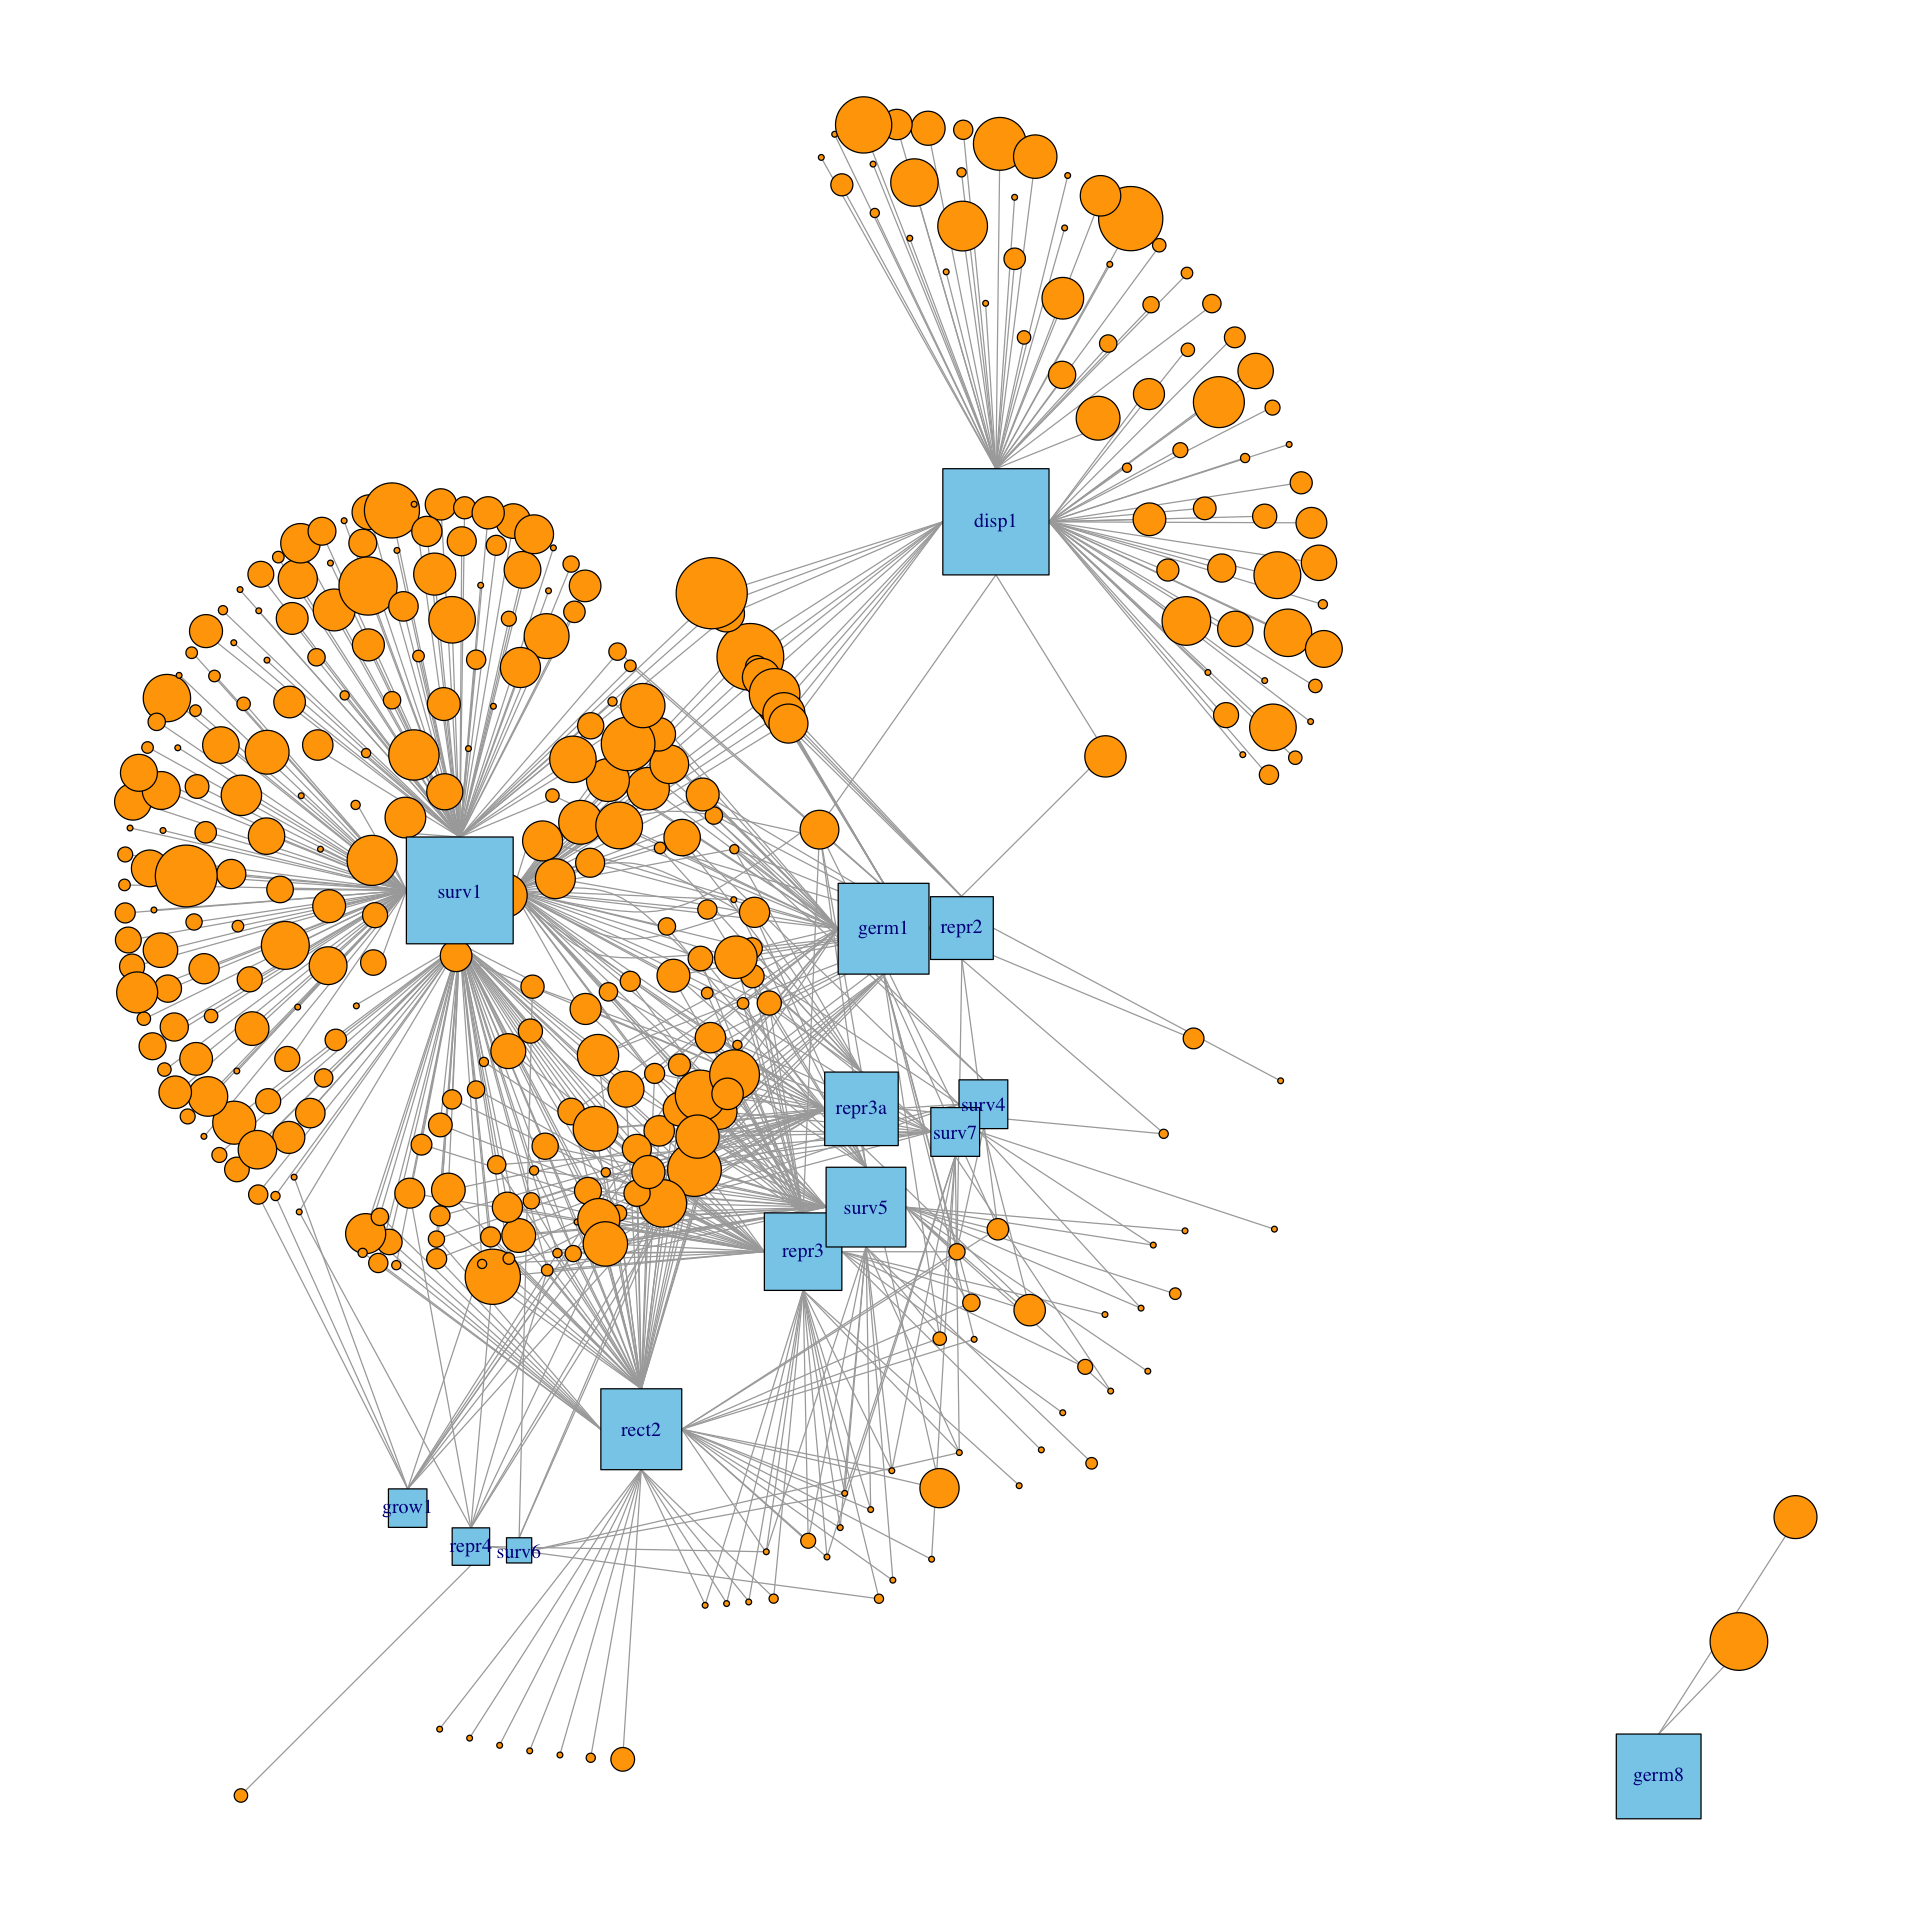

In [21]:
options(repr.plot.width=16, repr.plot.height=16) # Make plot larger

l <- layout_with_kk(traits_graph)
#l <- layout_nicely(g)
par(mar=c(0,0,0,0))
plot(traits_graph, layout=l,vertex.label.cex=1)

The `germ8` trait node is quite isolated, with large number of records from only two sources that are disconnected from the rest.

In [22]:
links |> filter(to=='germ8')

from                     to    main_source     spp
1 Collette Ooi 2021        germ8 austraits-6.0.0 991
2 Ooi Myerscough Auld 2007 germ8 austraits-6.0.0 170

We will exclude these three nodes from the graph:

In [23]:
nms <- c("germ8",links |> filter(to=='germ8') |> pull(from))
vertices_germ8 <- which(V(traits_graph)$name %in% nms)


Manual adjustment of the position of these three nodes:

In [24]:
traits_graph_layout <- layout_with_kk(traits_graph)
traits_graph_layout[vertices_germ8,1] <- traits_graph_layout[vertices_germ8,1]-10

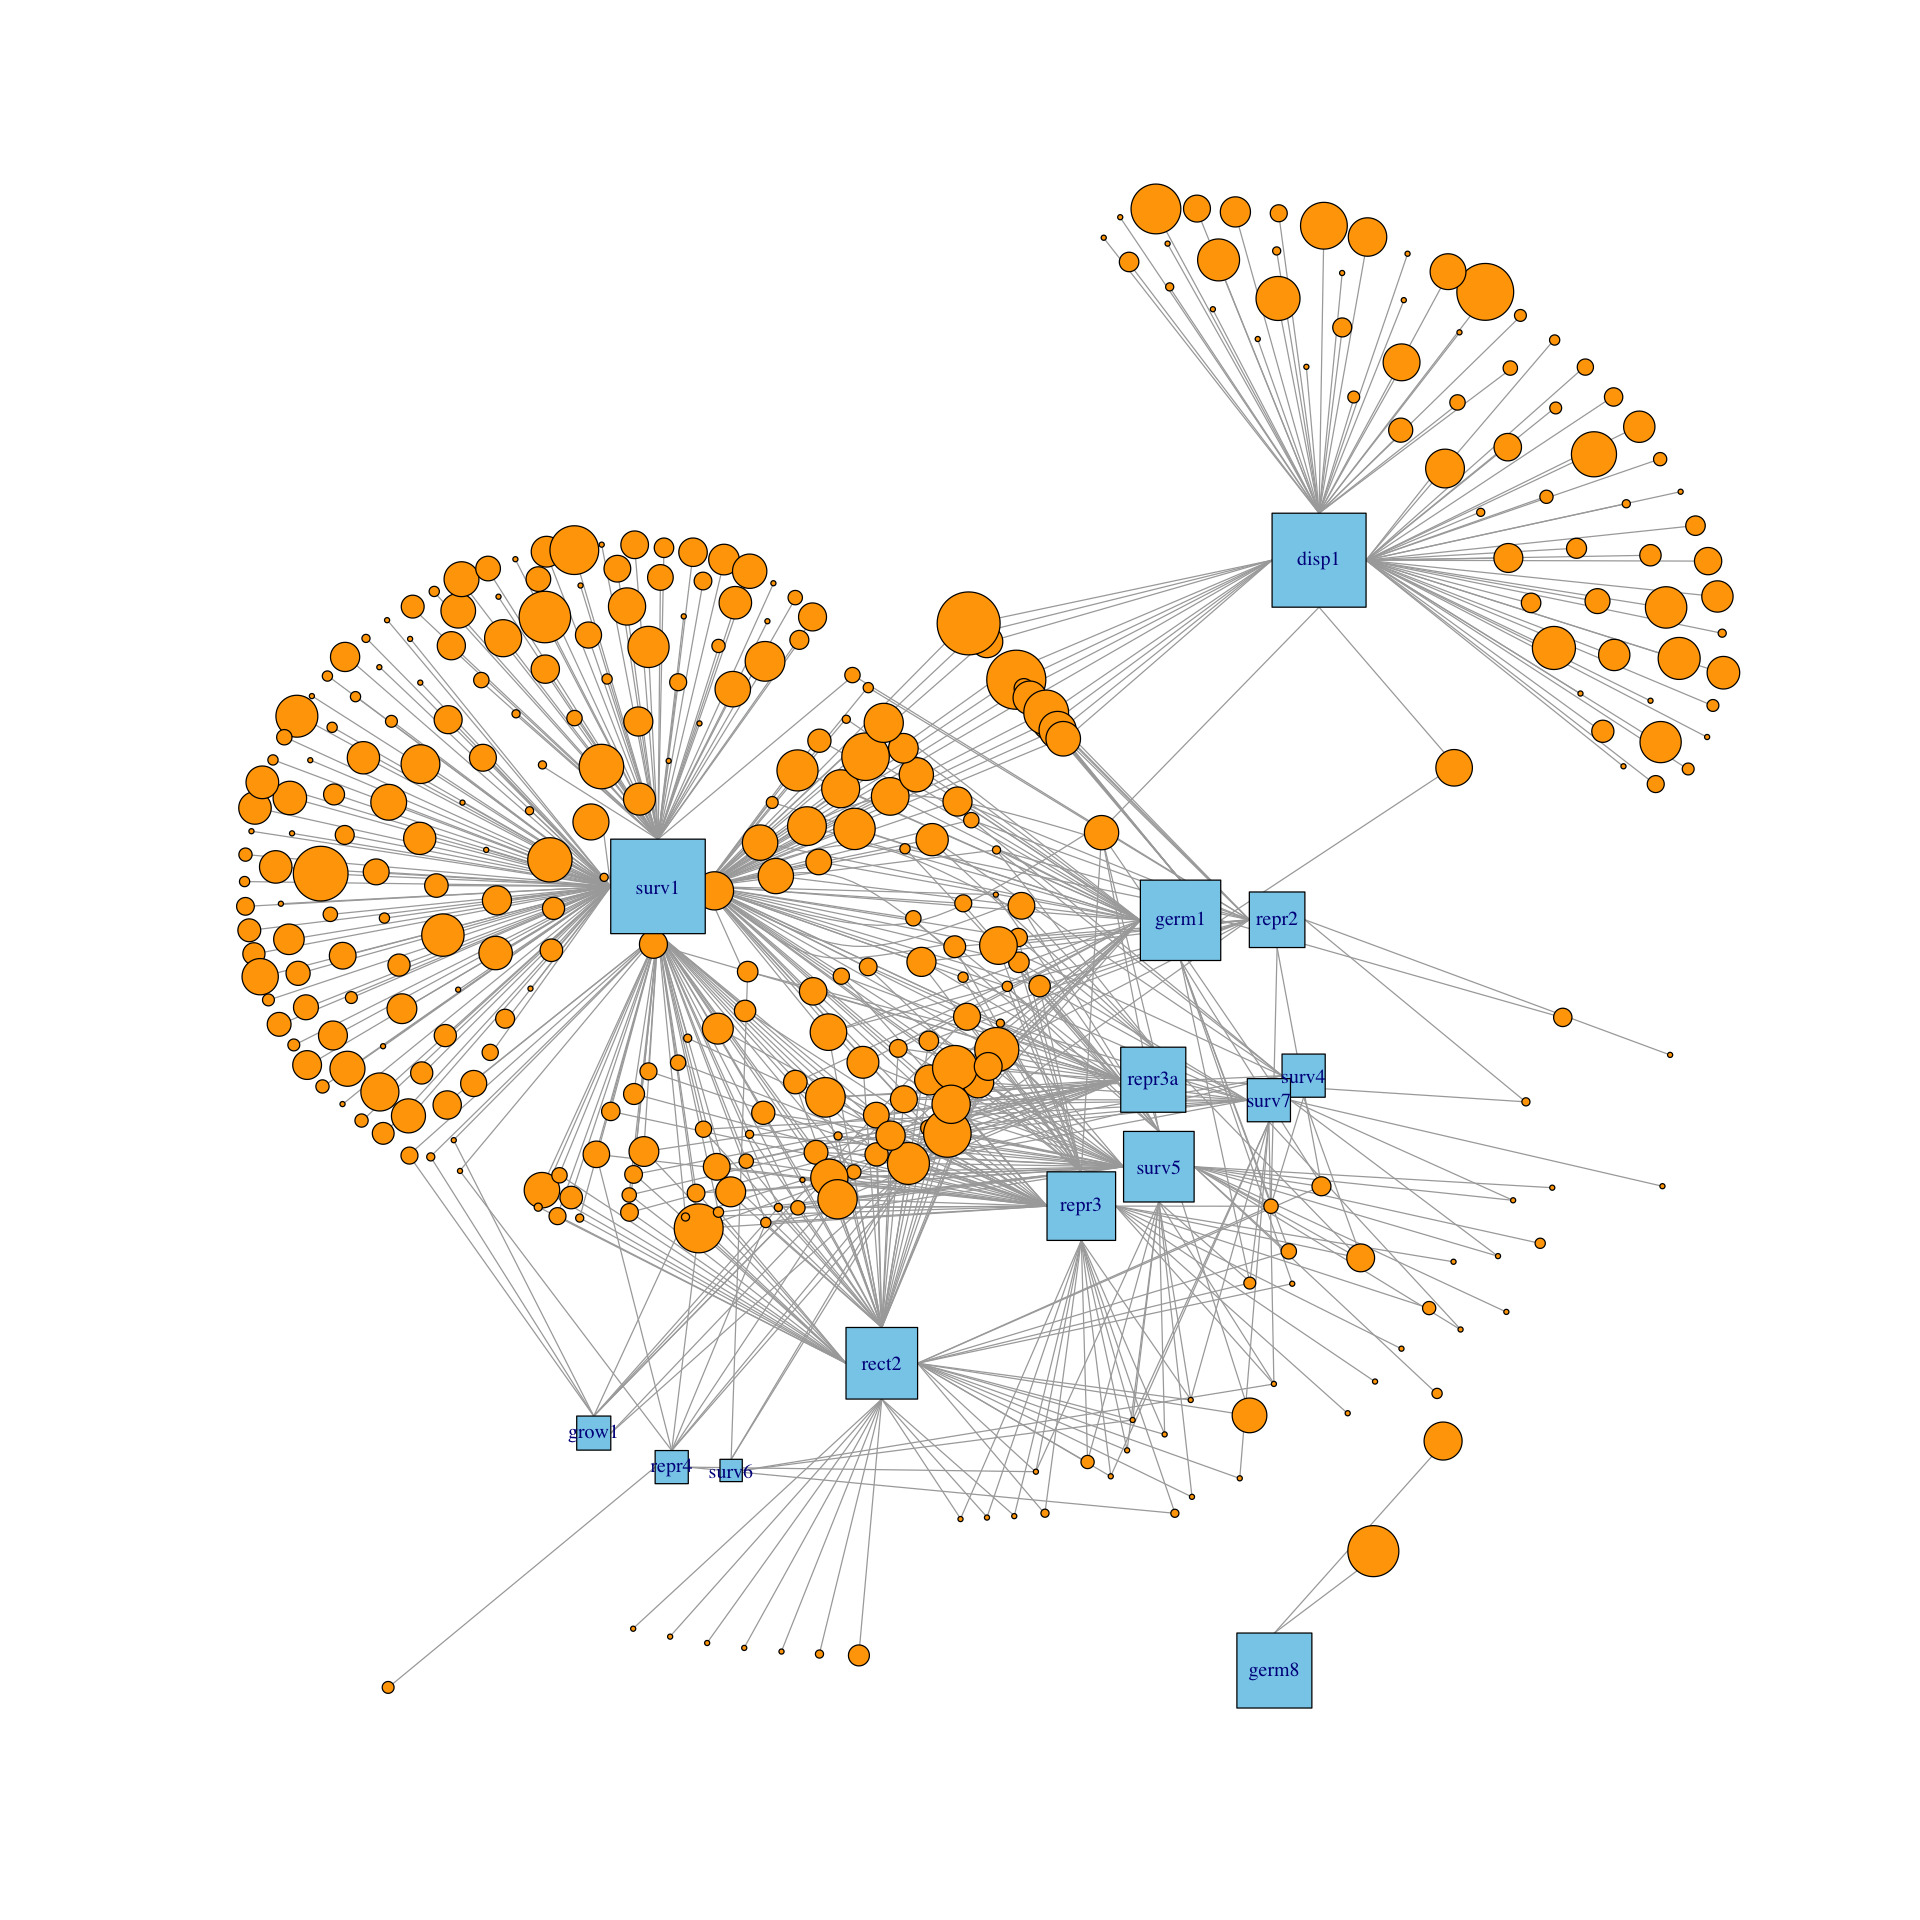

In [25]:
plot(traits_graph, layout=traits_graph_layout, vertex.label.cex=1)

In [26]:
g <- delete_vertices(traits_graph, vertices_germ8)

Now we can redraw the graph:

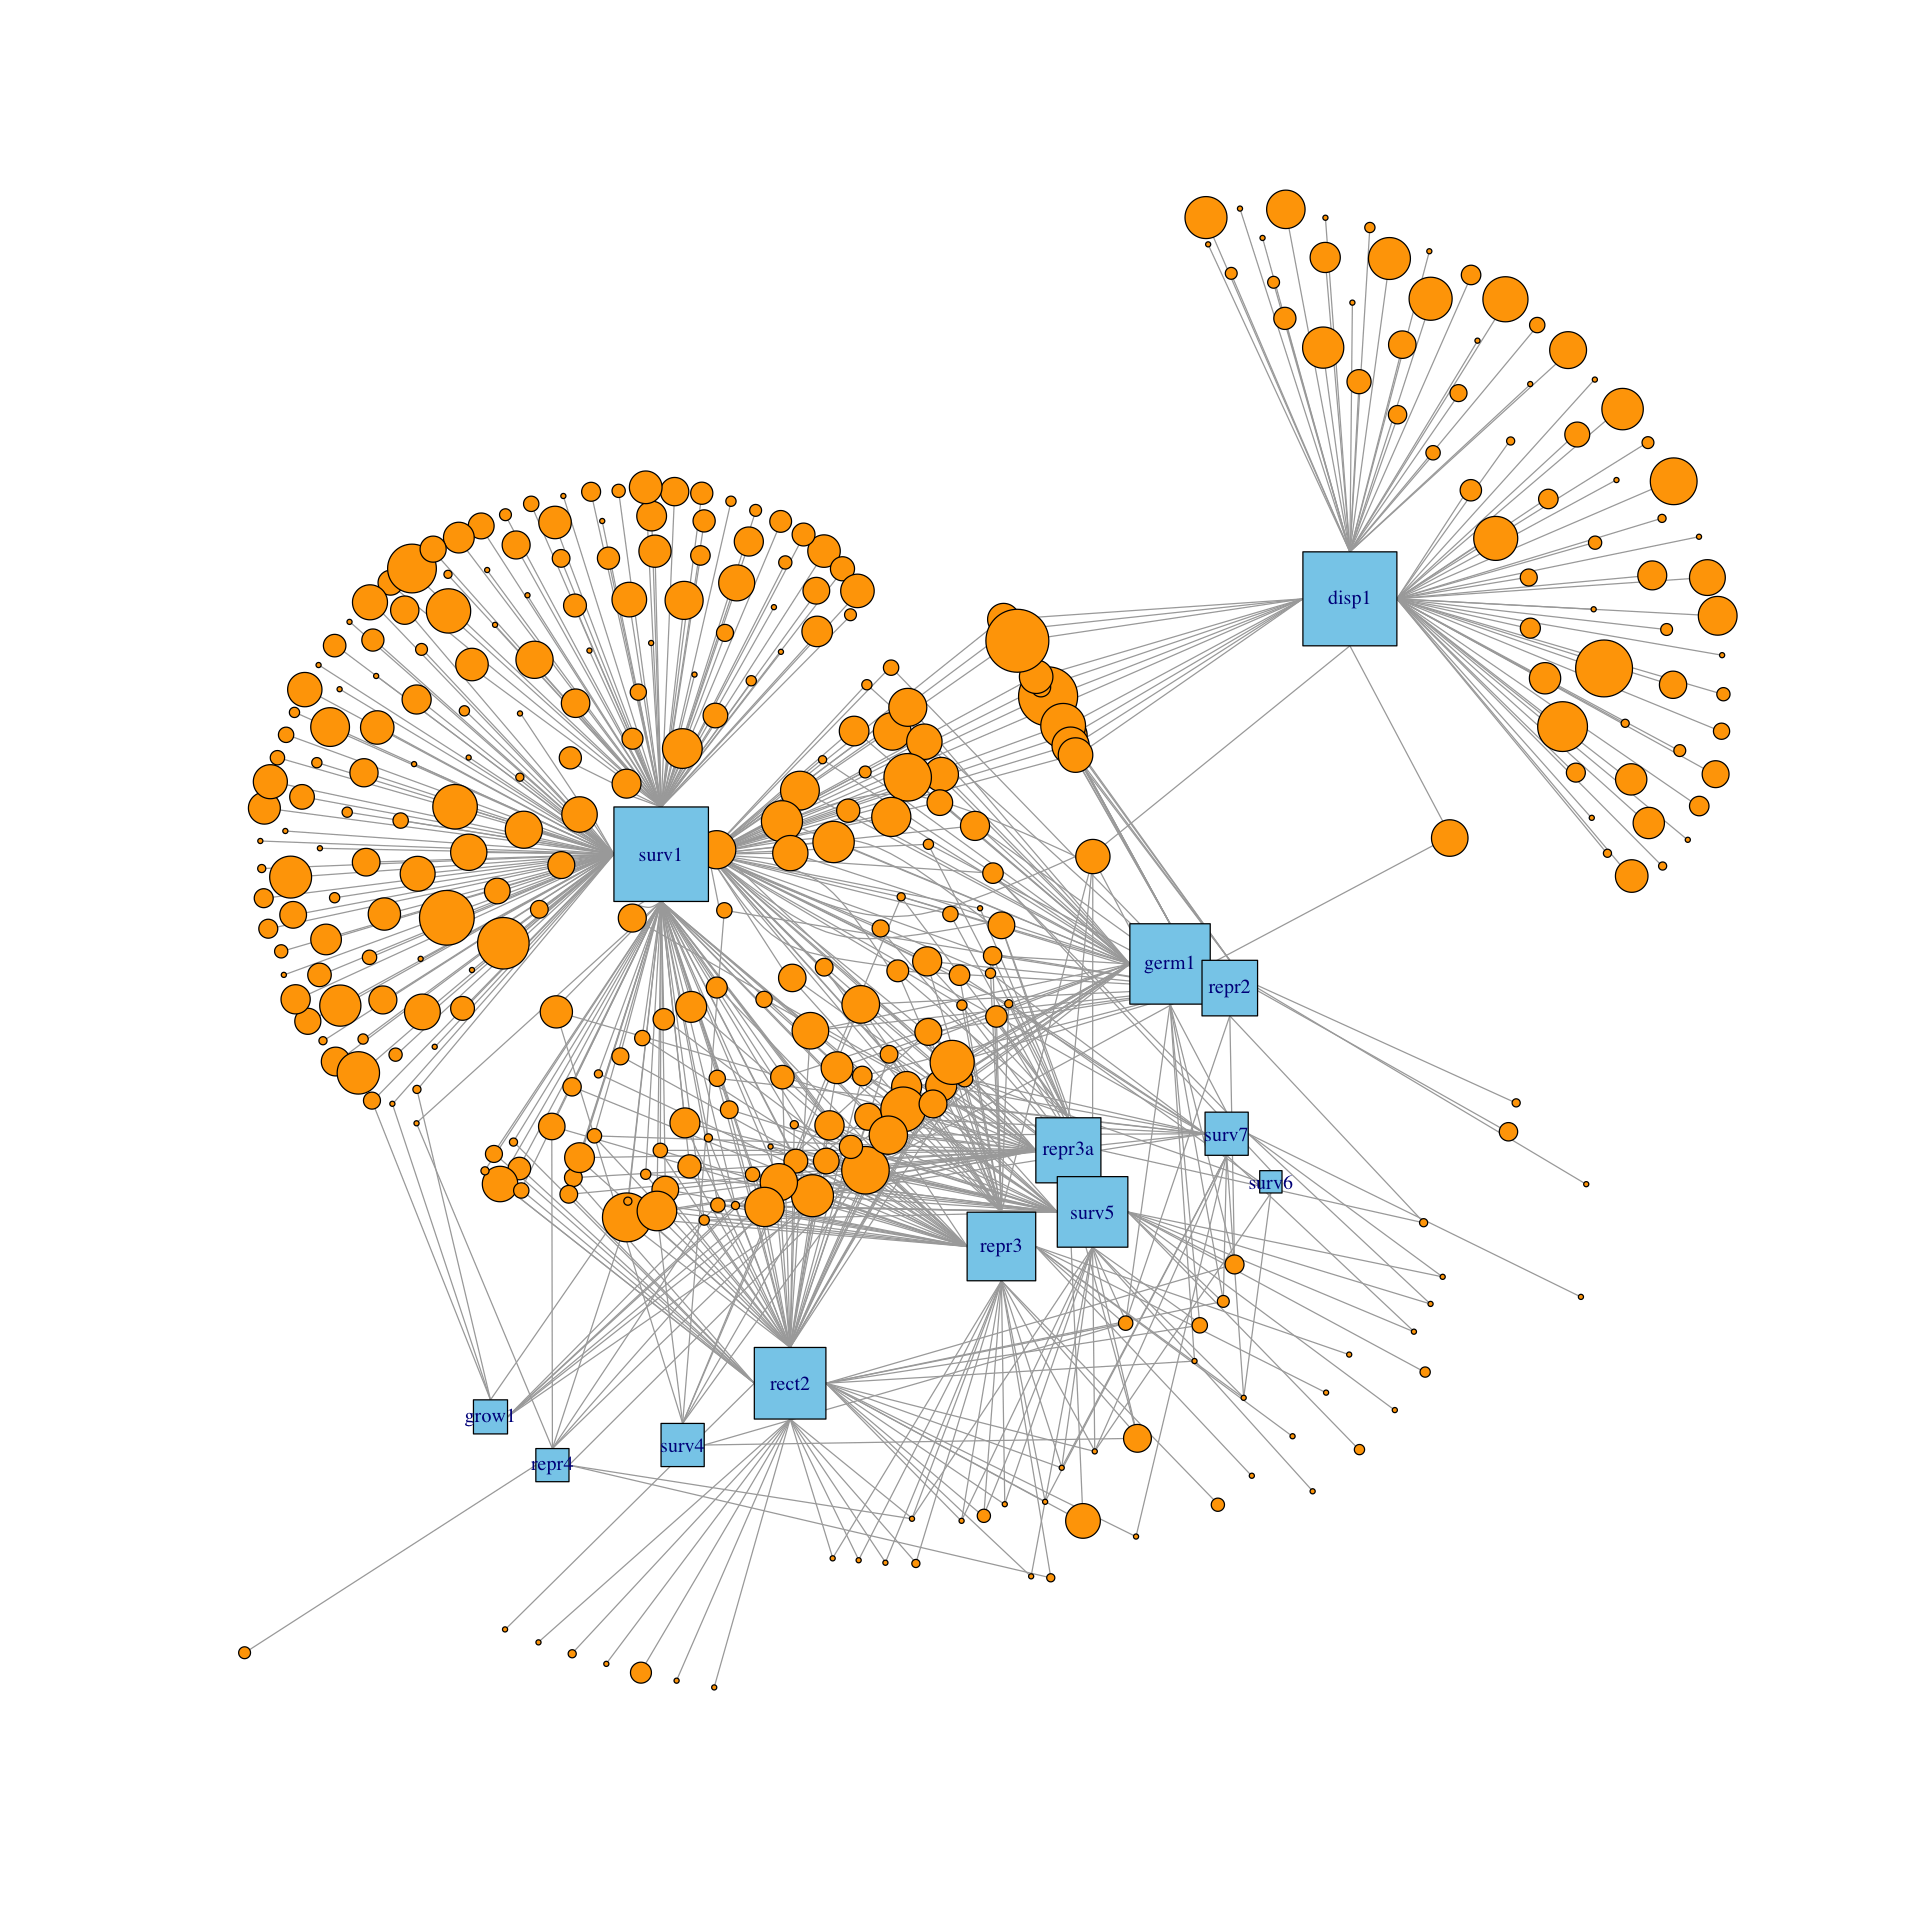

In [27]:
l <- layout_with_kk(g)
plot(g,layout=l,vertex.label.cex=1)

### Visualisation with ggraph

An alternative for graph visualisation using the package `ggraph`. This example reproduces the complete graph with an existing layout:

Warning message:
“The `trans` argument of `continuous_scale()` is deprecated as of ggplot2 3.5.0.
ℹ Please use the `transform` argument instead.”


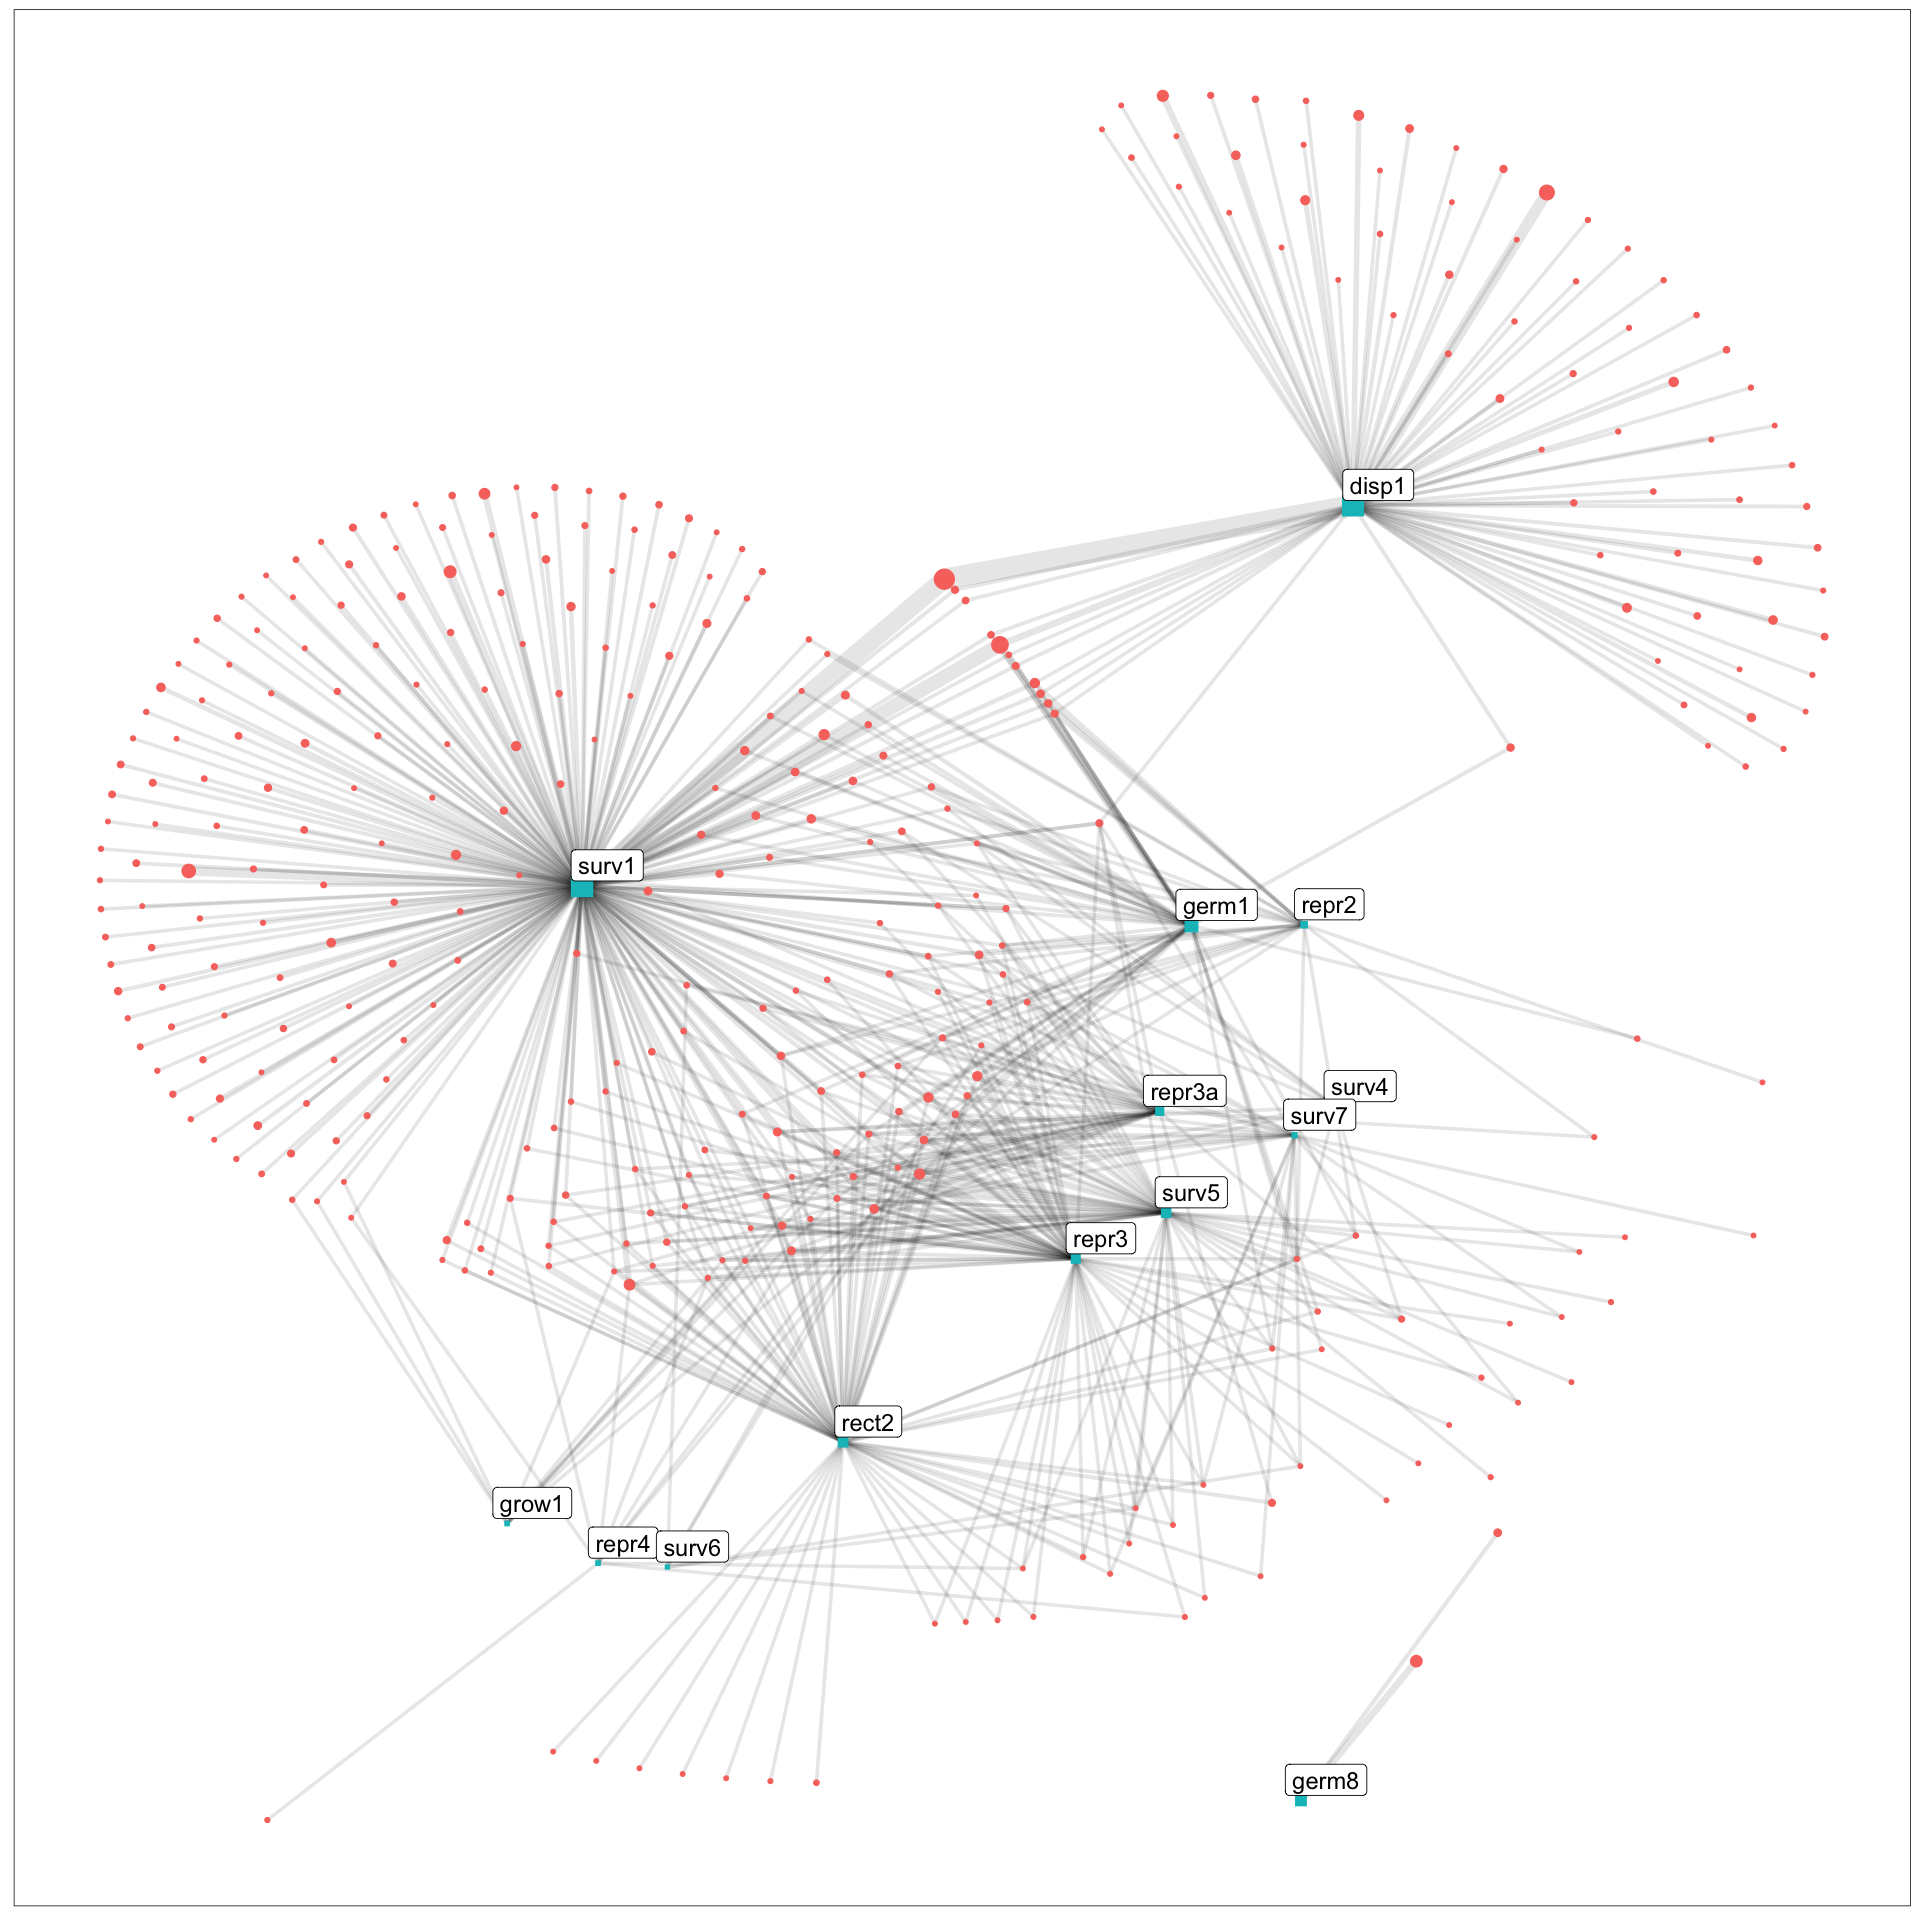

In [28]:
ggraph(traits_graph, layout=traits_graph_layout)+ 
  geom_edge_link0(aes(width = spp), edge_alpha = 0.1) + 
  geom_node_point(aes(size = spp, colour=type, shape = type)) + 
  scale_shape_manual(values=c("ref" = 19,  "trait" = 15)) +
  geom_node_label(aes(label = name, 
                      filter = type %in% "trait"), 
                  nudge_x = 0.25,
                  nudge_y = 0.25,
                 size = 5) + 
  ggforce::theme_no_axes() +
  theme(legend.position = "none") 

Or we can provide a graph and specify the algorithm for automatic layout:

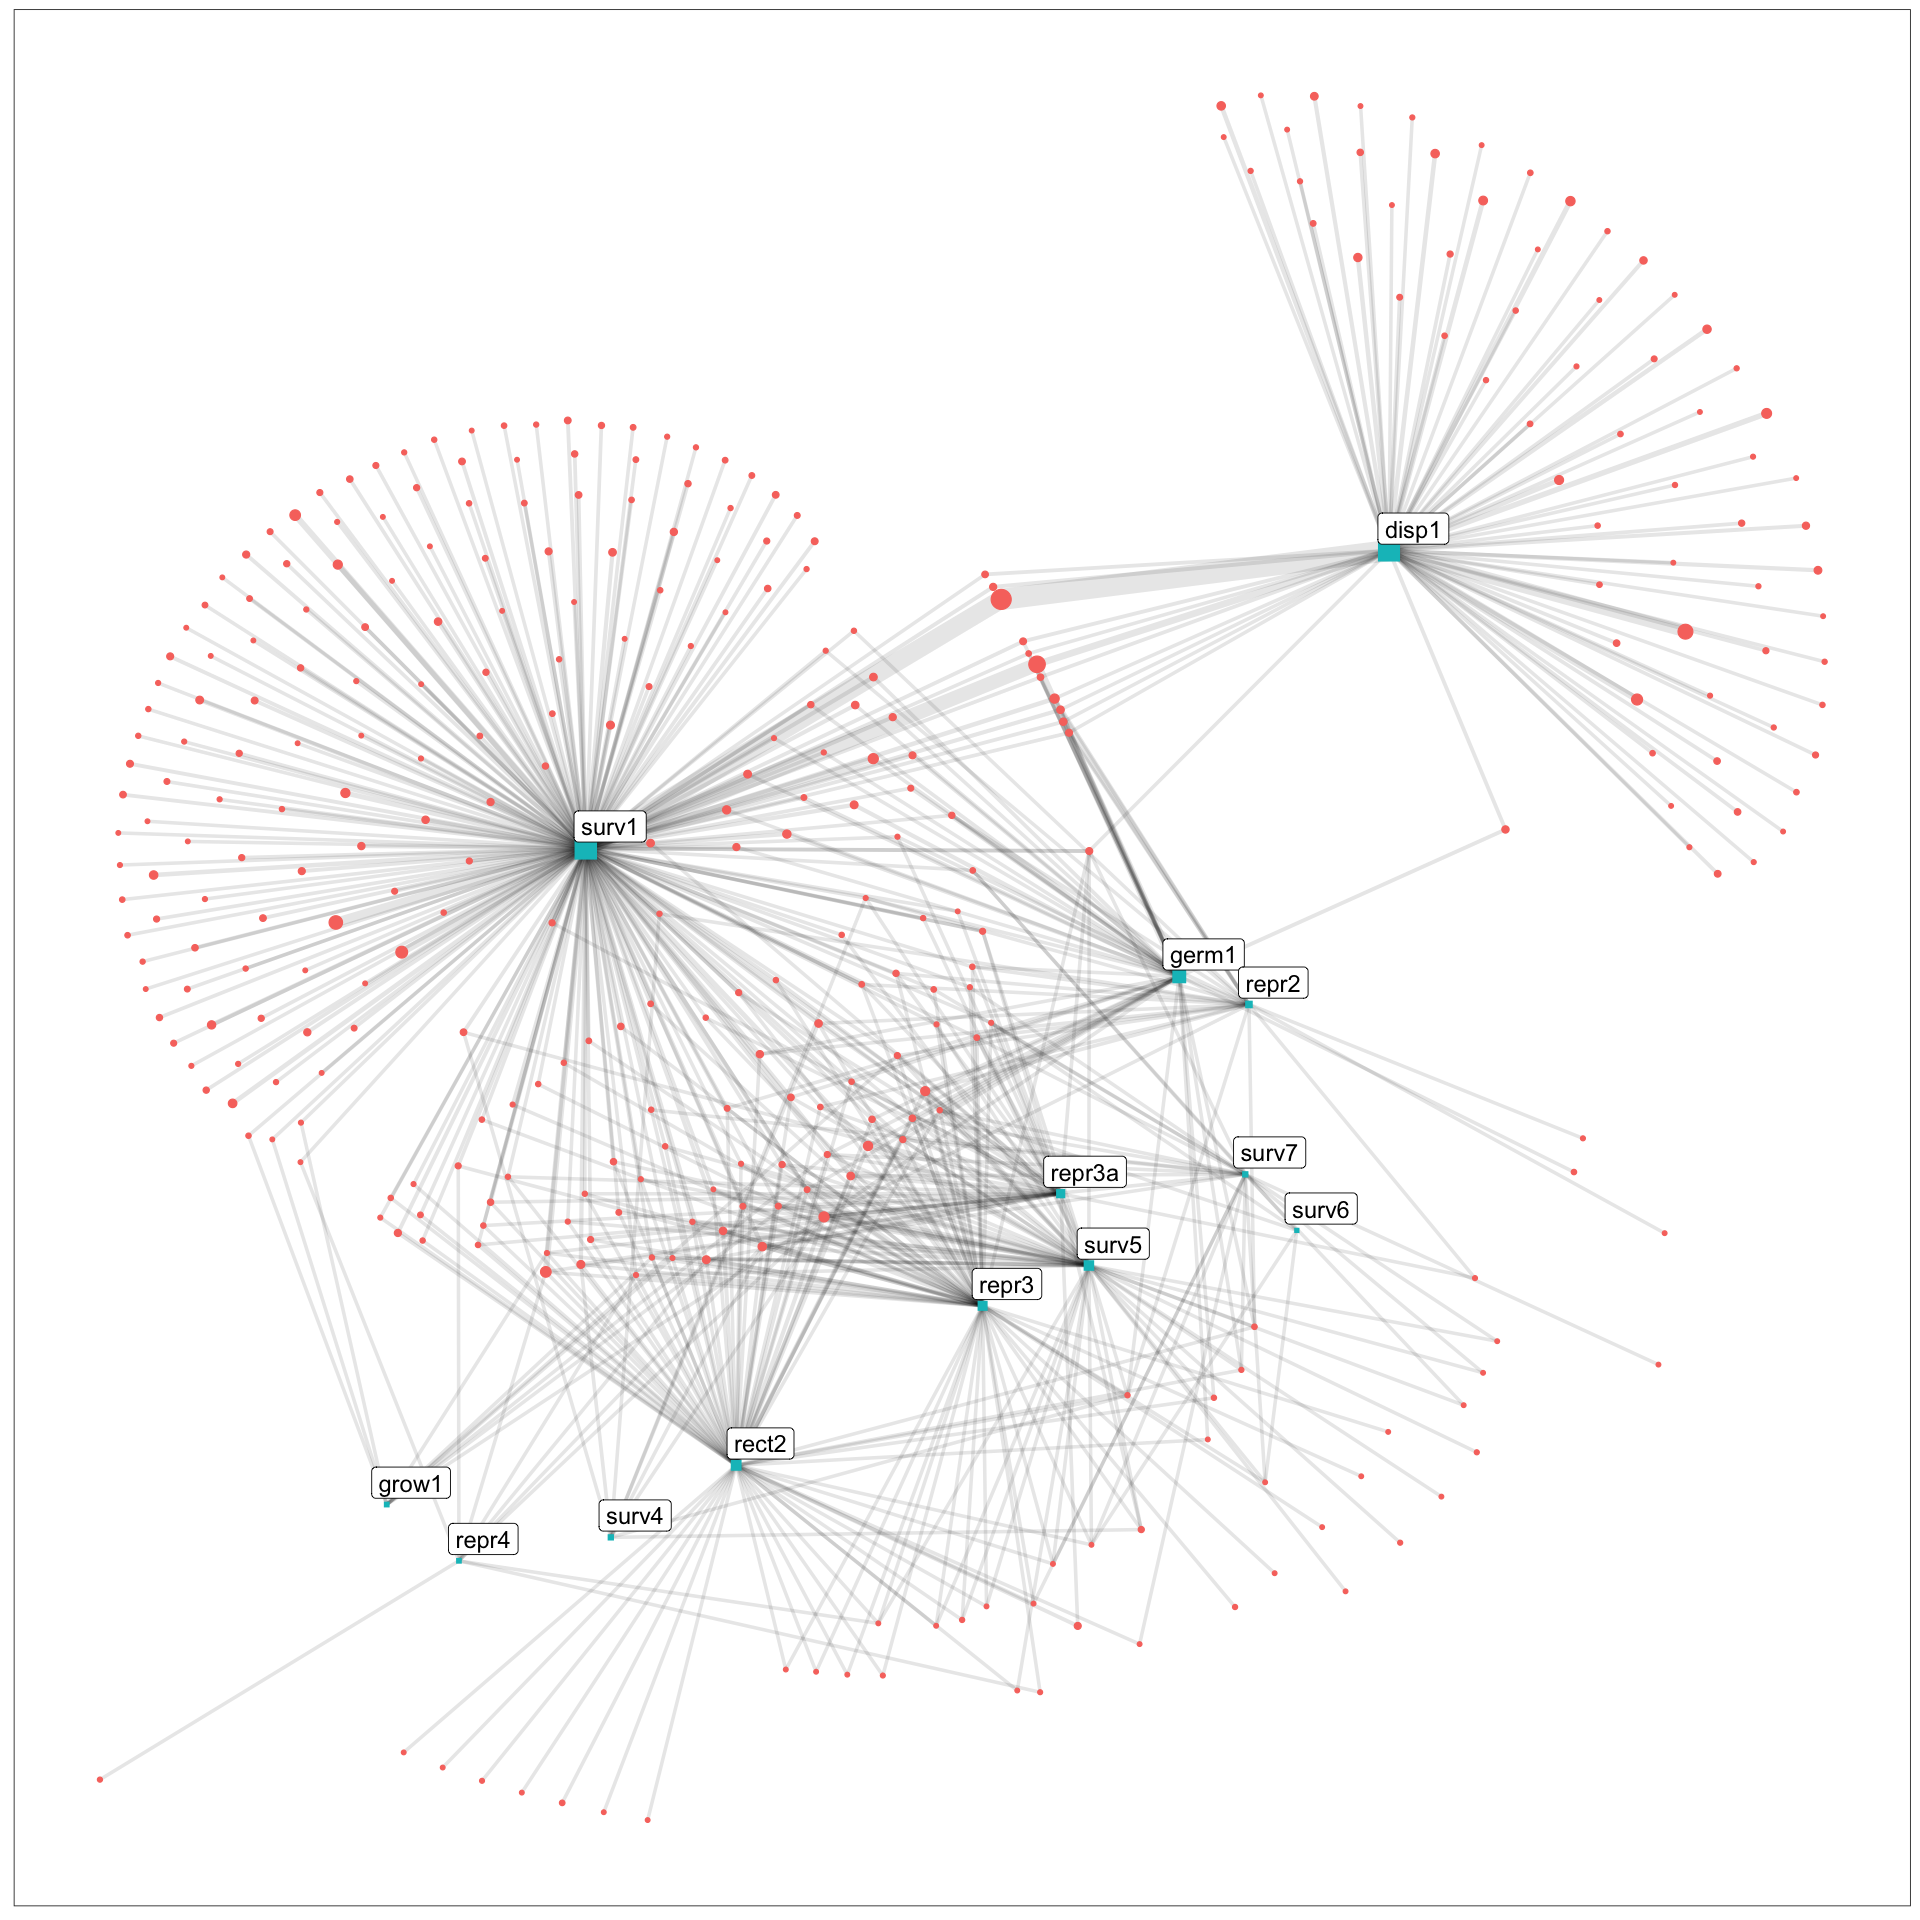

In [29]:
ggraph(g, 'igraph', algorithm = 'kk')+ 
  geom_edge_link0(aes(width = spp), edge_alpha = 0.1) + 
  geom_node_point(aes(size = spp, colour=type, shape = type)) + 
  scale_shape_manual(values=c("ref" = 19,  "trait" = 15)) +
  geom_node_label(aes(label = name, 
                      filter = type %in% "trait"), 
                  nudge_x = 0.25,
                  nudge_y = 0.25,
                 size = 5) + 
  ggforce::theme_no_axes() +
  theme(legend.position = "none") 

## That is it for now!

✅ Job done! 😎👌🔥

You can:
- go [back home](../Instructions-and-workflow.ipynb),
- continue navigating the repo on [GitHub](https://github.com/ces-unsw-edu-au/fireveg-db-exports)
- continue exploring the repo on [OSF](https://osf.io/h96q2/).
- visit the database at <http://fireecologyplants.net>